Before running this file, run `kimj4_exps/param_process.py > out.csv` to get the parameter output.
Note that that file pulls data from the parameter sweep which we've uploaded to aws, so make sure to pull that. In short, the process is:
* pull aws
* run `python param_process.py > out.csv`
* have fun with this notebook

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [21]:
num = []
depth = []
features = []
acc = []
prec = []
recall = []
f_score = []
first = True
with open('../kimj4_exps/out.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        if not first:
            num.append(float(row[0]))
            depth.append(float(row[1]))
            features.append(float(row[2]))
            prec.append(float(row[3]))
            recall.append(float(row[4]))
            acc.append(float(row[5]))
            f_score.append(float(row[6]))
        else:
            first = False
num = np.array(num)
depth = np.array(depth)
features = np.array(features)
acc = np.array(acc)
prec = np.array(prec)
recall = np.array(recall)
f_score = np.array(f_score)

As long as we have approximately more features than depth, we should get decent results:

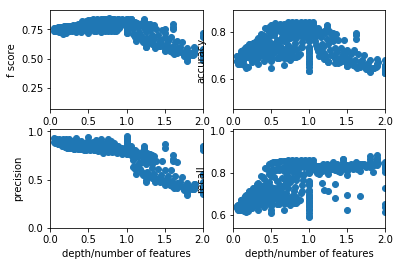

In [3]:
df_ratio = depth/features
plt.subplot(2,2,1)
plt.scatter(df_ratio, f_score)
plt.xlabel('depth/number of features')
plt.ylabel('f score')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,2)
plt.scatter(df_ratio, acc)
plt.xlabel('depth/number of features')
plt.ylabel('accuracy')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,3)
plt.scatter(df_ratio, prec)
plt.xlabel('depth/number of features')
plt.ylabel('precision')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,4)
plt.scatter(df_ratio, recall)
plt.xlabel('depth/number of features')
plt.ylabel('recall')
plt.gca().set_xlim([0,2])

plt.show()

It seems that a high number of features/depth gives good results. As a sanity check, increasing the depth or number of features, while holding the number of trees constant, gives better results as well (more information -> better-informed decisions -> more accurate forest). Finally, it seems that keeping a depth/features ratio of around/slightly under 1 is best for high-accuracy results

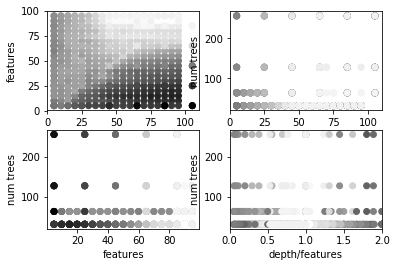

In [4]:
plt.subplot(2,2,1)
plt.scatter(depth, features, c=acc)
plt.xlabel('depth')
plt.ylabel('features')
plt.gray()

plt.subplot(2,2,2)
plt.scatter(depth, num, c=acc)
plt.xlabel('depth')
plt.ylabel('num trees')
plt.gray()

plt.subplot(2,2,3)
plt.scatter(features, num, c=acc)
plt.xlabel('features')
plt.ylabel('num trees')
plt.gray()


plt.subplot(2,2,4)
plt.scatter(df_ratio, num, c=acc)
plt.xlabel('depth/features')
plt.ylabel('num trees')
plt.gray()
plt.gca().set_xlim([0,2])

plt.show()

Here's the same graph, but with f1 instead of accuracy as the color.

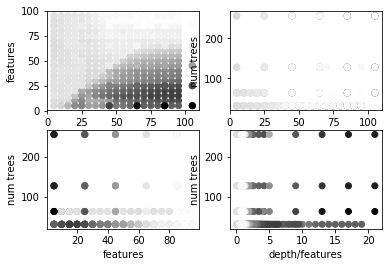

In [5]:
plt.subplot(2,2,1)
plt.scatter(depth, features, c=f_score)
plt.xlabel('depth')
plt.ylabel('features')
plt.gray()

plt.subplot(2,2,2)
plt.scatter(depth, num, c=f_score)
plt.xlabel('depth')
plt.ylabel('num trees')
plt.gray()

plt.subplot(2,2,3)
plt.scatter(features, num, c=f_score)
plt.xlabel('features')
plt.ylabel('num trees')
plt.gray()


plt.subplot(2,2,4)
plt.scatter(df_ratio, num, c=f_score)
plt.xlabel('depth/features')
plt.ylabel('num trees')
plt.gray()
# plt.gca().set_xlim([0,2])

plt.show()

There seems to be a local maximum around the mid .8's. Will increasing the # of trees on those points help?

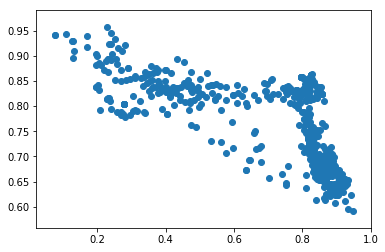

In [6]:
plt.scatter(prec, recall)
plt.show()

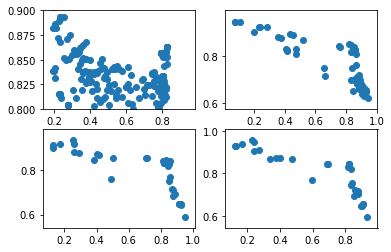

In [7]:
def filter_func():
    return num==tree_filter

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()])
plt.gca().set_ylim([.8,.9])
plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.show()

Doing some narrowing down. We're looking for that point slightly above .8 and .85 in the 32-tree example. 

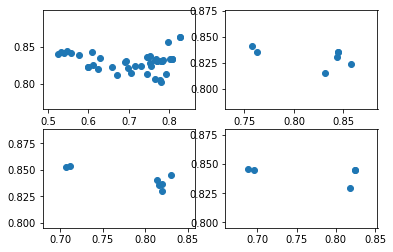

In [8]:
def filter_func():
    right_tree = num==tree_filter
    right_params = np.logical_and(np.logical_and(np.greater_equal(df_ratio, np.ones(df_ratio.shape)),
                                  np.greater(features, 50*np.ones(features.shape))),
                                  np.greater(depth, 50*np.ones(features.shape)))
    return np.logical_and(right_tree, right_params)

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.show()

And finally, finding the exact point

[ 32.  32.]
[ 95.  95.]
[ 90.  95.]
[ 0.82617882  0.79621241]
[ 0.8626045   0.85691365]


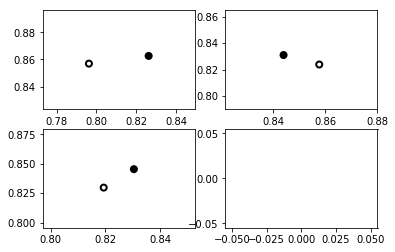

In [9]:
def filter_func():
    right_tree = num==tree_filter
    right_params = np.logical_and(features > 85, depth > 90)
    return np.logical_and(right_tree, right_params)

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()], c=features[filter_func()],linewidths=2, edgecolors='black')
print(num[filter_func()])
print(depth[filter_func()])
print(features[filter_func()])
print(prec[filter_func()])
print(recall[filter_func()])

plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()],c=features[filter_func()],linewidths=2, edgecolors='black')

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()],c=features[filter_func()],linewidths=2, edgecolors='black')

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()],c=features[filter_func()],linewidths=2, edgecolors='black')

plt.show()

Looks like our max is at `(32,95,90)` for `(n_trees, depth, features)`. 

[ 128.  128.  128.  128.   32.   32.   32.   32.   32.   32.   64.   64.
   64.   64.]
[ 90.  95.  90.  95.  90.  95.  90.  95.  90.  95.  90.  95.  90.  95.]
[ 70.  70.  95.  95.  70.  70.  90.  90.  95.  95.  70.  70.  95.  95.]
[ 0.85288696  0.81937815  0.8303965   0.81937815  0.8288104   0.79906955
  0.82617882  0.79621241  0.82617882  0.79621241  0.83541566  0.85767427
  0.84397259  0.85767427]
[ 0.8291648   0.82972137  0.84539322  0.82972137  0.86300936  0.85731687
  0.8626045   0.85691365  0.8626045   0.85691365  0.84793687  0.82383147
  0.83097594  0.82383147]


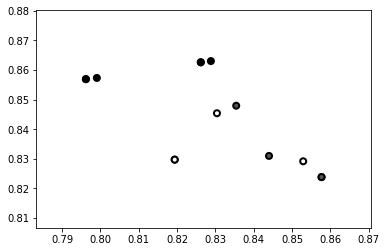

In [10]:
def filter_func():
    # right_tree = np.logical_or(np.logical_or(num==32, num==64),num==128)
    ok_features = [90, 95]
    ok_depths = [70,90,95]
    right_params = np.logical_and(np.isin(features, ok_features), np.isin(depth, ok_depths))
    
    # return np.logical_and(right_tree, right_params)
    return right_params

print(num[filter_func()])
print(features[filter_func()])
print(depth[filter_func()])
print(prec[filter_func()])
print(recall[filter_func()])
plt.scatter(prec[filter_func()], recall[filter_func()], c=num[filter_func()], linewidths=2, edgecolors='black')

plt.show()

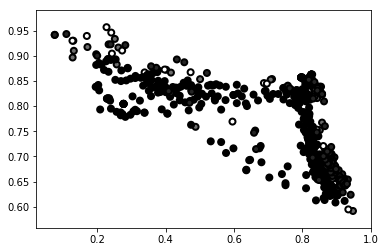

In [11]:
plt.scatter(prec, recall, c=num,linewidths=2, edgecolors='black')
plt.show()

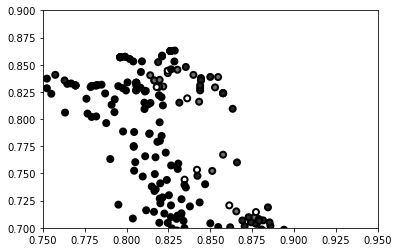

In [12]:
plt.scatter(prec, recall, c=num,linewidths=2, edgecolors='black')
plt.gca().set_xlim([.75,.95])
plt.gca().set_ylim([.7,.9])
plt.show()

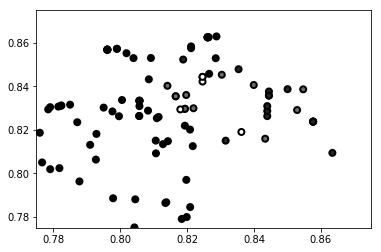

In [13]:
plt.scatter(prec, recall, c=num,linewidths=2, edgecolors='black')
plt.gca().set_xlim([.775,.875])
plt.gca().set_ylim([.775,.875])
plt.show()

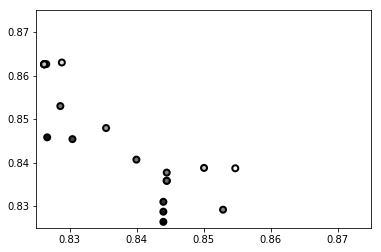

In [14]:
fltr = np.logical_and(np.greater(prec,.825), np.greater(recall, .825))

plt.scatter(prec[fltr], recall[fltr], c=f_score[fltr],linewidths=2, edgecolors='black')
plt.gca().set_xlim([.825,.875])
plt.gca().set_ylim([.825,.875])
plt.show()

looks like our best points are ~.855,.84 and .83,.86

Since recall is a little more important for this task, I'll focus on .83,.86

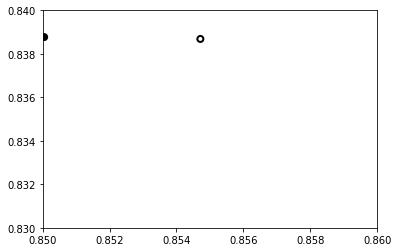

[ 128.   64.]
[ 65.  70.]
[ 85.  85.]
[ 0.85471285  0.85004701]


In [15]:
gt = np.logical_and(np.greater(prec,.85), np.greater(recall, .83))
lt = np.logical_and(np.less(prec, .86), np.less(recall, .84))
fltr = np.logical_and(gt, lt) 
# fltr = gt

plt.scatter(prec[fltr], recall[fltr], c=f_score[fltr],linewidths=2, edgecolors='black')
plt.gca().set_xlim([.85,.86])
plt.gca().set_ylim([.83,.84])
plt.show()

print(num[fltr])
print(depth[fltr])
print(features[fltr])
print(prec[fltr])

# Plotting new data

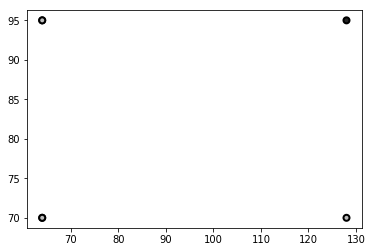

In [16]:
#want to find:
#num in [64, 128, 256]
#depth in [70, 95]
#features in [90, 95]

ok_nums = np.isin(num, (64, 128, 256))
ok_depth = np.isin(depth, (70, 95))
ok_features = np.logical_and(np.isin(features, (90, 95)), np.logical_not(np.logical_and(num==128,features==95)))
# ok_features = (95)

fltr = np.logical_and(np.logical_and(ok_nums, ok_depth), ok_features)

plt.scatter(num[fltr], depth[fltr], c=f_score[fltr],linewidths=2, edgecolors='black')
plt.show()

[ 128.  128.   64.   64.   64.   64.]
[ 70.  95.  70.  70.  95.  95.]
[ 90.  90.  90.  95.  90.  95.]
[ 0.85288696  0.8303965   0.83541566  0.85767427  0.84397259  0.85767427]
[ 0.8291648   0.84539322  0.84793687  0.82383147  0.83097594  0.82383147]


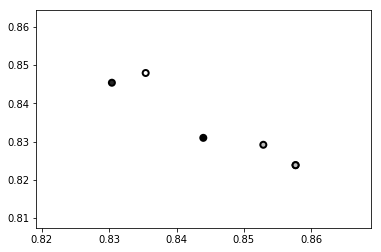

In [17]:
plt.scatter(prec[fltr], recall[fltr], c=f_score[fltr],linewidths=2, edgecolors='black')
print(num[fltr])
print(depth[fltr])
print(features[fltr])
print(prec[fltr])
print(recall[fltr])
plt.show()

[ 128.  128.   32.   32.   64.   64.   64.   64.]
[ 70.  95.  70.  95.  70.  70.  95.  95.]
[ 90.  90.  90.  90.  90.  95.  90.  95.]
[ 0.85288696  0.8303965   0.8288104   0.82617882  0.83541566  0.85767427
  0.84397259  0.85767427]
[ 0.8291648   0.84539322  0.86300936  0.8626045   0.84793687  0.82383147
  0.83097594  0.82383147]


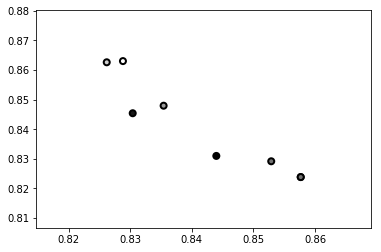

In [18]:
ok_nums_exp = np.isin(num, (32,64,128,256))
ok_features = np.logical_and(np.isin(features, (90, 95)), np.logical_not(np.logical_and(np.isin(num,(32,128)),features==95)))
exp_fltr = np.logical_and(np.logical_and(ok_nums_exp, ok_depth), ok_features)
print(num[exp_fltr])
print(depth[exp_fltr])
print(features[exp_fltr])
print(prec[exp_fltr])
print(recall[exp_fltr])
plt.scatter(prec[exp_fltr], recall[exp_fltr], c=f_score[exp_fltr],linewidths=2, edgecolors='black')
# plt.gca().set_xlim([.82, .86])
# plt.gca().set_ylim([.81,.86])
plt.show()

# compare to other vals

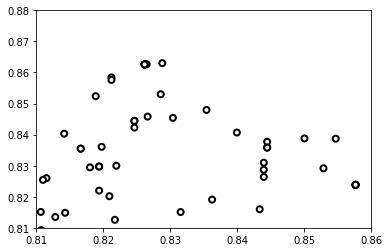

In [19]:
plt.scatter(prec, recall, c=f_score,linewidths=2, edgecolors='black')
plt.gca().set_xlim(.81,.86)
plt.gca().set_ylim(.81, .88)
plt.show()

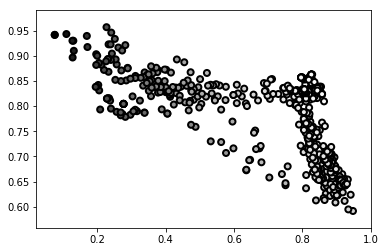

In [20]:
plt.scatter(prec, recall, c=f_score,linewidths=2, edgecolors='black')
plt.show()

# More in-depth analysis of data points

In [25]:
vals = []
with open('../data/params/param/32.70.90.txt') as f:
    lines = f.readlines()
    val = []
    for line in lines[1:]:
        if not line.startswith('average'):
            val.append(list(map(lambda x: float(x), line[1:-2].split(','))))
    vals.append(('32.70.90',val))
print(vals[0][1][1])

[0.8, 0.875, 0.8450704225352113, 0.8358208955223881, 104.94725131988525, 4.947458744049072]


In [26]:
with open('../data/params/param/128.65.85.txt') as f:
    lines = f.readlines()
    val = []
    for line in lines[1:]:
        if not line.startswith('average'):
            val.append(list(map(lambda x: float(x), line[1:-2].split(','))))
    vals.append(('128.65.85',val))

In [31]:
vals[0][1]

[[0.8823529411764706,
  0.8823529411764706,
  0.8873239436619719,
  0.8823529411764706,
  106.16163349151611,
  4.930840969085693],
 [0.8,
  0.875,
  0.8450704225352113,
  0.8358208955223881,
  104.94725131988525,
  4.947458744049072],
 [0.8,
  0.8,
  0.8028169014084507,
  0.8000000000000002,
  101.02756977081299,
  4.9511682987213135],
 [0.8604651162790697,
  0.8409090909090909,
  0.8169014084507042,
  0.8505747126436781,
  103.51621985435486,
  6.474504232406616],
 [0.9302325581395349,
  0.8695652173913043,
  0.8732394366197183,
  0.898876404494382,
  109.01977324485779,
  4.92956280708313],
 [0.8666666666666667,
  0.8125,
  0.8591549295774648,
  0.8387096774193549,
  103.2804102897644,
  5.173095464706421],
 [0.7368421052631579,
  0.9655172413793104,
  0.8450704225352113,
  0.835820895522388,
  97.73061895370483,
  5.092473268508911],
 [0.696969696969697,
  0.8214285714285714,
  0.7887323943661971,
  0.7540983606557378,
  103.37880873680115,
  4.927096843719482],
 [0.846153846153846

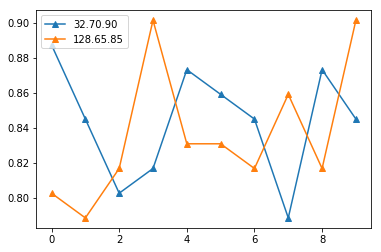

In [39]:
labels = [vals[x][0] for x in range(len(vals))]
accs = [[y[2] for y in vals[x][1]] for x in range(len(vals))]
x = range(len(accs[0]))
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, accs[0], marker="^", label=labels[0])
ax.plot(x, accs[1], marker="^", label=labels[1])

plt.legend(loc=2)
plt.show()

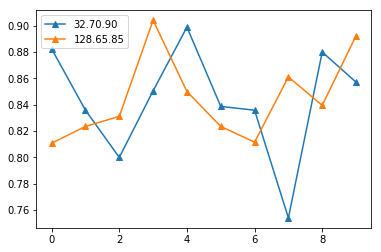

In [42]:
f1s = [[y[3] for y in vals[x][1]] for x in range(len(vals))]
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, f1s[0], marker="^", label=labels[0])
ax.plot(x, f1s[1], marker="^", label=labels[1])

plt.legend(loc=2)
plt.show()

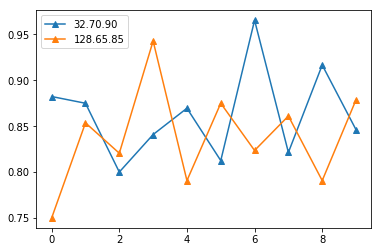

In [43]:
recalls = [[y[1] for y in vals[x][1]] for x in range(len(vals))]
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, recalls[0], marker="^", label=labels[0])
ax.plot(x, recalls[1], marker="^", label=labels[1])

plt.legend(loc=2)
plt.show()